In [1]:
#Pesky import stuff
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import cmath
import nibabel as nib
import random
import cv2
import scipy
import skimage
from scipy import ndimage
from scipy import signal
from scipy import stats
from skimage.transform import warp, AffineTransform

from skimage import transform, draw, filters

<h2><center>Load Images</center></h2>

### Function to get the Middle coronal slice of a nib_img

Website for slice information: https://faculty.washington.edu/chudler/slice.html

In [2]:
"""MiddleCoronalSlice takes a nib_img and returns its coronal slice"""
def MiddleCoronalSlice(nib_img):
    nib_img_data = nib_img.get_fdata()
    coronal_slice = nib_img_data[:, :, len(nib_img_data[0][0])//2]
    return coronal_slice

### Use following cell on OSX

In [4]:
# training_images_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Training/IBSR_0'+ str(i) + '/images/analyze/IBSR_0' + str(i) +'_ana.img' for i in range(1,7)]
# training_segments_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Training/IBSR_0'+ str(i) + '/segmentation/analyze/IBSR_0' + str(i) +'_seg_ana.img' for i in range(1,7)]

# validation_images_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Validation/IBSR_'+ i + '/images/analyze/IBSR_' + i +'_ana.img' for i in ['07', '15']]
# validation_segments_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Validation/IBSR_'+ i + '/segmentation/analyze/IBSR_' + i +'_seg_ana.img' for i in ['07', '15']]

# #location of testing images
# testing_images_loc = ['08','09','10','11','12','13','14','16','17']

# #where the directory of testing images will be stored
# testing_images_dir = []

# for loc in testing_images_loc:
#     testing_images_dir.append('/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Testing/IBSR_'+ loc + '/images/analyze/IBSR_' + loc + '_ana.img')

# #arrays of middle coronal slices of training images and segments
# training_images = []
# training_segments = []

# #arrays of middle coronal slices of validation images and segments
# validation_images = []
# validation_segments = []

# #array of middle coronal slice of testing images
# testing_images = []

# #BY DEFINITION there are an equal amount of images as there are segments so arrays are the 
# #same size and can therefore be grouped together

# #load up all the training images and segments in order
# for i in range(len(training_images_dir)):
#     training_images.append(MiddleCoronalSlice(nib.load(training_images_dir[i])))
#     training_segments.append(MiddleCoronalSlice(nib.load(training_segments_dir[i])))

# #load up all the validation images in order
# for i in range(len(validation_images_dir)):
#     validation_images.append(MiddleCoronalSlice(nib.load(validation_images_dir[i])))
#     validation_segments.append(MiddleCoronalSlice(nib.load(validation_segments_dir[i])))

# #load up all testing images in order
# for directory in testing_images_dir:
#     testing_images.append(MiddleCoronalSlice(nib.load(directory)))

<h2><center>1: 6 Parameter Affine Registration</center></h2>

#### Sub Functions

In [5]:
"""
Input(s): -moving image
          -A_x: a global x scalar - type float (must be > 0)
          -A_y: a global y scalar - type float (must be > 0)          
          -theta: rotation angle in degrees; 0<=theta<=360
          -t_x = d_m: translation on x-axis - type int
          -t_y = d_n: translation on y-axis - type int
          -s: shear 
          -out_size: ouput (fixed image) grid size - i.e an array in terms of fixed_image.shape (height,width)

Output image has a size of the output grid size and pixel values are obtained by resampling the input image onto 
the output grid via applying the geometric transformation:
    1)Global scale multiplied with a rotation matrix
    2)Translation

Returns: fimg: the output as a result of applying geometric transformation to input image
"""
def Transformer(moving_img, A_x, A_y, theta, d_m, d_n, s, out_grid_size):
    #input image dimensions
    ih,iw = len(moving_img), len(moving_img[0])
    #get height(N) and width(M) of output image from input paramater out_grid_size
    oh, ow = out_grid_size[0], out_grid_size[1]
    
    #the following allows our transformation to occur about the center of the image
    shift_y, shift_x, _ = (np.array((oh, ow,1))-1) / 2.
    shift_fwd = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
    shift_back = transform.SimilarityTransform(translation=[shift_x, shift_y])    
    
    #calculate the transform using input parameters
    tform = AffineTransform(scale=(A_x, A_y), rotation=np.deg2rad(theta), shear=s,
                        translation=(d_m, d_n))
    
    #warp moving image to output grid based on tform - bilinear interpolation used over nearest neighbor
    fimg = warp( moving_img , ( shift_fwd + ( tform + shift_back )).inverse, 
                order=1, clip=False, preserve_range=True, mode='symmetric')
    
    return fimg

In [6]:
"""
Input(s): -Params (a length-6 vector of geometric transformation parameters)
                - i.e an array of (A_x, A_y, theta, t_x, t_y, s)
          -fixed image 
          -moving image
Returns: -Structural Similarity Measure (SSIM) defined as 
            SSIM(x,y) = (2*mu_x*mu_y + C)*(2*sigma_xy + D) / (mu_x^2 + mu_y^2 + C)*(sigma_x^2 + simga_y^2 + D)
"""
def Loss(Params, fixed_img, moving_img):    
    #compute geometrically transformed image using input parameters
    gt_img = Transformer(moving_img, *Params, fixed_img.shape) # *Params unpacks the array
    
    #make images grayscale
    grayA = skimage.color.rgb2gray(gt_img)
    grayB = skimage.color.rgb2gray(fixed_img)
    
    #compute SSIM
    output = skimage.measure.compare_ssim(grayA, grayB)     
    
    #Return -SSIM since our goal is to minimize loss function
    return -output

In [7]:
"""
Optimizer computes the optimal geometric transformation parameters, and returns them alongside the 
geometric transformation of the geometric image with those parameters

Input(s): -fixed image
          -moving image
Returns:
          -optimal_params: optimal geometric transformation parameters
          -transf_img: geometrically transformed moving image with optimal_params
"""
def Optimize(fixed_img, moving_img):
    
    #many initial guesses were tested but the identity worked best
    opt_params = scipy.optimize.minimize(Loss, (1,1,0,0,0,0), args = (fixed_img,moving_img), method = 'BFGS')

    transf_img = Transformer(moving_img, *opt_params.x, fixed_img.shape)
    return opt_params.x, transf_img

# def Optimize(fixed_img, moving_img):
    
#     opt_params = scipy.optimize.fmin(Loss, (1,1,0,0,0,0), args = (fixed_img, moving_img))

#     transf_img = Transformer(moving_img, *opt_params, fixed_img.shape)
#     return opt_params, transf_img

#### Geometric Registration Function

In [8]:
"""
Geometric differs from Optimize in the fact that it optimizes the normalized fixed and moving images beo
Input(s): -fixed image
          -moving image
Returns:  -geometrically transformed moving image using optimal parameters
"""
def geometricRegistration(fixed_img, moving_img):
    #get height (N) and width(M) of fixed image 
    height,width,c = fixed_img.shape
    
    #initialize an array of zeros of size MxN
    normalizedImg = np.zeros((height,width))
    #compute the normalized fixed image
    normalized_fixed_img = cv2.normalize(fixed_img, 0, 255, cv2.NORM_MINMAX)
    
    #initialize an array of zeros of size MxN
    normalizedImg2 = np.zeros((height,width))
    #compute the normalized moving image
    normalized_moving_img = cv2.normalize(moving_img, 0, 255, cv2.NORM_MINMAX)
    
    #compute optimal parameters, and the geometric transformed image with these optimal parameters
    opt_params, transf_img = Optimize(normalized_fixed_img,normalized_moving_img)
    
    #return the geometrically transformed image with optimal paramenters
    return opt_params, transf_img

<h2><center>Resampling Each Training Image onto a Testing Image</center></h2>

In [9]:
"""
transf_img[k] is the optimally transformed image from geometrickRegistration(fixed_img[j], moving_img[i])
for each valid indices i,j - where i,j integers such that 0<=j<=8, 0<=i<=5.

Thus k is an integer such that 0<=k<=53 and there are 54 total transformed images
with a corresponding optimal transform

opt_params[k] has the same invariant
"""
opt_params = []
transf_img = []

opt_params_v = []
#for each validation image (j = 0,1,2,3,4,5,6,7,8)
for fixed_img in testing_images:
    #for each moving image (i = 0,1,2,3,4,5)
    for moving_img in training_images: 
        op, tf = geometricRegistration(fixed_img, moving_img)
        opt_params.append(op)
        #append the geometricRegistration(fixed_img,moving_img) to transf_img by invariant above
        transf_img.append(tf)

"""ADDING VALIDATION IMAGES TO THE TRAINING SET"""
        
#for each validation image (j = 0,1,2,3,4,5,6,7,8)
for fixed_img in testing_images:#MAPPED ONTO TESTIM
    #for each moving image (i = 0,1)
    for moving_img in validation_images: #VALIDATION IS NOW MOVING IMAGE
        op, tf = geometricRegistration(fixed_img, moving_img)
        opt_params_v.append(op)
        #append the geometricRegistration(fixed_img,moving_img) to transf_img by invariant above
        transf_img.append(tf)

In [10]:
#seg_img_0 is each training segment i (0<=i<=5) mapped onto testing image j (j = 0)
seg_img_0 = [Transformer(training_segments[i], *opt_params[i], testing_images[0].shape) for i in range(6)]

#seg_img_1 is each training segment i (0<=i<=5) mapped onto testing image j (j = 1)
seg_img_1 = [Transformer(training_segments[i], *opt_params[6+i], testing_images[1].shape) for i in range(6)]

#seg_img_2 is each training segment i (0<=i<=5) mapped onto testing image j (j = 2)
seg_img_2 = [Transformer(training_segments[i], *opt_params[12+i], testing_images[2].shape) for i in range(6)]

#seg_img_3 is each training segment i (0<=i<=5) mapped onto testing image j (j = 3)
seg_img_3 = [Transformer(training_segments[i], *opt_params[18+i], testing_images[3].shape) for i in range(6)]

#seg_img_4 is each training segment i (0<=i<=5) mapped onto testing image j (j = 4)
seg_img_4 = [Transformer(training_segments[i], *opt_params[24+i], testing_images[4].shape) for i in range(6)]

#seg_img_5 is each training segment i (0<=i<=5) mapped onto testing image j (j = 5)
seg_img_5 = [Transformer(training_segments[i], *opt_params[30+i], testing_images[5].shape) for i in range(6)]

#seg_img_6 is each training segment i (0<=i<=5) mapped onto testing image j (j = 6)
seg_img_6 = [Transformer(training_segments[i], *opt_params[36+i], testing_images[6].shape) for i in range(6)]

#seg_img_7 is each training segment i (0<=i<=5) mapped onto testing image j (j = 7)
seg_img_7 = [Transformer(training_segments[i], *opt_params[42+i], testing_images[7].shape) for i in range(6)]

#seg_img_8 is each training segment i (0<=i<=5) mapped onto testing image j (j = 8)
seg_img_8 = [Transformer(training_segments[i], *opt_params[48+i], testing_images[8].shape) for i in range(6)]


In [11]:
"""ADD VALIDATION IMAGES TO PROPER LOCATION"""
for i in range(2):
    seg_img_0.append(Transformer(validation_segments[i], *opt_params_v[i], testing_images[0].shape))
    seg_img_1.append(Transformer(validation_segments[i], *opt_params_v[i+2], testing_images[1].shape))
    seg_img_2.append(Transformer(validation_segments[i], *opt_params_v[i+4], testing_images[2].shape))
    seg_img_3.append(Transformer(validation_segments[i], *opt_params_v[i+6], testing_images[3].shape))
    seg_img_4.append(Transformer(validation_segments[i], *opt_params_v[i+8], testing_images[4].shape))
    seg_img_5.append(Transformer(validation_segments[i], *opt_params_v[i+10], testing_images[5].shape))
    seg_img_6.append(Transformer(validation_segments[i], *opt_params_v[i+12], testing_images[6].shape))
    seg_img_7.append(Transformer(validation_segments[i], *opt_params_v[i+14], testing_images[7].shape))
    seg_img_8.append(Transformer(validation_segments[i], *opt_params_v[i+16], testing_images[8].shape))

<h2><center>4: Computing the Most Frequent Training Label for Every Pixel on Testing Subject Grid</center></h2>

 #### Making a "Set" of Images

In [12]:
"""
The v_0_set is the stack of the 6 training images mapped onto the first validation images grid (i.e a stack of 6 images)
The v_1_set is the stack of the 6 training images mapped onto the first validation images grid (i.e a stack of 6 images)
"""
#intialize a 256x256xj array of zeros such that each "level" j contains seg_img_X[j]
t_0_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 08 (testing_images[0]) +validation segment
t_1_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 09 (testing_images[1]) +validation segment
t_2_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 10 (testing_images[2]) +validation segment
t_3_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 11 (testing_images[3]) +validation segment
t_4_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 12 (testing_images[4]) +validation segment
t_5_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 13 (testing_images[5]) +validation segment
t_6_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 14 (testing_images[6]) +validation segment
t_7_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 16 (testing_images[7]) +validation segment
t_8_set = np.zeros((256,256,8)) #set of training segments mapped onto testing image IBSR 17 (testing_images[8]) +validation segment

#store images in proper places
for j in range (8):
    t_0_set[:,:,j] = seg_img_0[j][:,:,0]
    t_1_set[:,:,j] = seg_img_1[j][:,:,0]
    t_2_set[:,:,j] = seg_img_2[j][:,:,0]
    t_3_set[:,:,j] = seg_img_3[j][:,:,0]
    t_4_set[:,:,j] = seg_img_4[j][:,:,0]
    t_5_set[:,:,j] = seg_img_5[j][:,:,0]
    t_6_set[:,:,j] = seg_img_6[j][:,:,0]
    t_7_set[:,:,j] = seg_img_7[j][:,:,0]
    t_8_set[:,:,j] = seg_img_8[j][:,:,0]

### Computing Most Frequent Training Label For a Set of Images

In [13]:

def mode(array):
    most = max(list(map(array.count, array)))
    return list(set(filter(lambda x: array.count(x) == most, array)))


def MFTL(img_set):
    """
MFTL computes the most frequent training label between a set of images. If there is a tie, a random one is chosen.

Want to compute the MODE between each pixel (m,n) at level j (m in [M], n in [N], j in [J]) for a "level-set" 
of images and store it in a new output image where each pixel (m,n) of the output image is the MODE

Input: J MxN images in an (M,N,J) array (J = 6)
Returns: Image where each pixel is the most frequent training label between each pixel [m][n] between all [j] levels
    """
    M = len(img_set)
    N = len(img_set[0])
    J = len(img_set[0][0])
    
    #where to store output image
    output = np.zeros((256,256))
    finalimg = np.zeros((256,256))
    for m in range(M):
        for n in range(N):
            #l is the list of intensity values it (m,n) between j images
            l = [img_set[m][n][j] for j in range(J)]
            #nz is the an array of the indices for which l was nonzero
            nz = np.nonzero(l)
            #compute the mode of pixel (m,n) between the j images
            mode1 = max(mode(l))
            
            #if the mode is zero but there were nonzero intensity values at (m,n) for some image j
            if(mode1 == 0 and len(nz[0]) > 0):
                #lvals is a list of values among j images that were nonzero in l at pixel (m,n)
                lvals = [l[nz[0][k]] for k in range(len(nz[0]))]
                #compute new mode of nonzero pixels
                mode2 = max(mode(lvals))
                #set output to new mode
                output[m][n] = mode2
            else:
                #the (m,n) output pixel is equal to that mode
                output[m][n] = mode1
    
    return output

#### Compute MFTL of Each Set and Visualize Results

Text(0.5, 1.0, 'Most Frequent Training Label of T_8 Set')

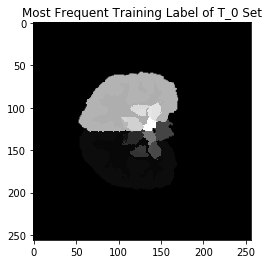

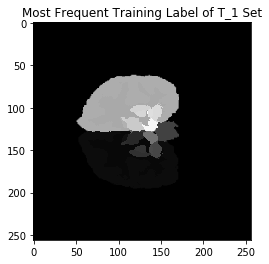

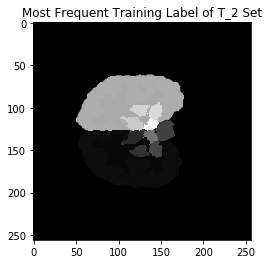

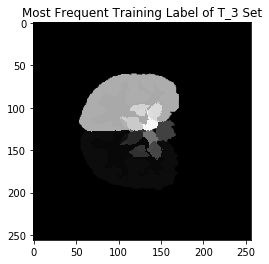

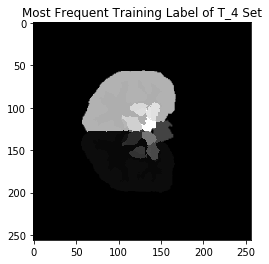

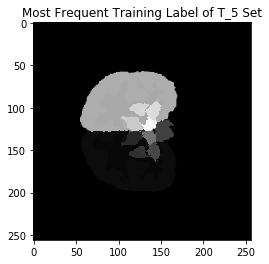

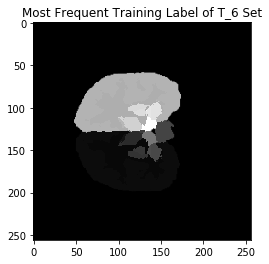

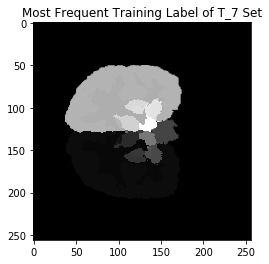

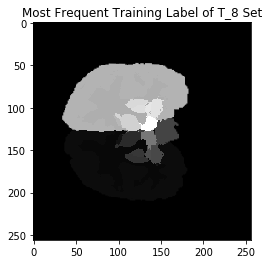

In [14]:
fig = plt.figure(1)
t0_MFTL = MFTL(t_0_set) #MFTL of t_0_set
plt.imshow(t0_MFTL, cmap = 'gray',)
plt.title('Most Frequent Training Label of T_0 Set')
fig.savefig('plott0mftl.png')

fig = plt.figure(2)
t1_MFTL = MFTL(t_1_set) #MFTL of t_1_set
plt.imshow(t1_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_1 Set')
fig.savefig('plott1mftl.png')

plt.figure(3)
t2_MFTL = MFTL(t_2_set) #MFTL of t_2_set
plt.imshow(t2_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_2 Set')


plt.figure(4)
t3_MFTL = MFTL(t_3_set) #MFTL of t_3_set
plt.imshow(t3_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_3 Set')

plt.figure(5)
t4_MFTL = MFTL(t_4_set) #MFTL of t_4_set
plt.imshow(t4_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_4 Set')

plt.figure(6)
t5_MFTL = MFTL(t_5_set) #MFTL of t_5_set
plt.imshow(t5_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_5 Set')

plt.figure(7)
t6_MFTL = MFTL(t_6_set) #MFTL of t_6_set
plt.imshow(t6_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_6 Set')

plt.figure(8)
t7_MFTL = MFTL(t_7_set) #MFTL of t_7_set
plt.imshow(t7_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_7 Set')

plt.figure(9)
t8_MFTL = MFTL(t_8_set) #MFTL of t_8_set
plt.imshow(t8_MFTL, cmap = 'gray')
plt.title('Most Frequent Training Label of T_8 Set')


<h2><center>Export Results for Competition</center></h2>

In [15]:
"""returns an array with 1's in the location where the input image is equal to the region of interest, 0 otherwise"""
def binary_Mask(img, ROI):
    imgb = np.array(img)
    return (imgb == ROI)

In [16]:
bMask_2 = [] #an array where each index is the binary mask of where the training label == ROI 2
bMask_3 = [] #an array where each index is the binary mask of where the training label == ROI 3
bMask_41 = [] #an array where each index is the binary mask of where the training label == ROI 41
bMask_42 = [] #an array where each index is the binary mask of where the training label == ROI 42

for MFTL in [t0_MFTL, t1_MFTL, t2_MFTL, t3_MFTL, t4_MFTL, t5_MFTL, t6_MFTL, t7_MFTL, t8_MFTL]:
        bMask_2.append(binary_Mask(MFTL, 2))
        bMask_3.append(binary_Mask(MFTL, 3))
        bMask_41.append(binary_Mask(MFTL, 41))
        bMask_42.append(binary_Mask(MFTL, 42))

In [17]:
"""
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
"""
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [18]:
import pandas as pd

### ids: list containing the 36 IDs as described###
regions = ['-left-wm', '-left-cortex', '-right-wm', '-right-cortex']
numbers = ['8','9','10','11','12','13','14','16','17']
labels = []

for num in numbers:
    for reg in regions:
        labels.append(num+reg)

### data: list containing the 36 binary segmentation masks in RLE format in proper order###
data = []
for i in range(len(bMask_2)):
    data.append(rle_encode(bMask_2[i]))
    data.append(rle_encode(bMask_3[i]))
    data.append(rle_encode(bMask_41[i]))
    data.append(rle_encode(bMask_42[i]))
    
df = pd.DataFrame({"Id": labels, "Predicted": data})
df.to_csv('submission.csv', index = False) 